In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

MEMORY = 4*1024

gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.set_logical_device_configuration(gpus[0],
                                              [tf.config.LogicalDeviceConfiguration(memory_limit=MEMORY)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:        
    # Memory growth must be set before GPUs have been initialized
    print(e) 
    
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

2023-02-06 01:05:23.679708: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-06 01:05:23.925890: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-06 01:05:24.659202: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /end/home/rh2310/lib:/end/soft/Linux_2.6_64/lib::/end/home/rh2310/.conda/envs/tensorflo

1 Physical GPUs, 1 Logical GPUs


2023-02-06 01:05:31.412355: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-06 01:05:35.022897: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4096 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:e3:00.0, compute capability: 8.6


In [2]:
from local_utils import *

In [3]:
sim_name = "Koch_Meinhardt_5"
x_slice=slice(0,99,1)#slice(30,65,1)#slice(50,65,1)#
y_slice=slice(0,99,1)#slice(50,85,1)#slice(70,85,1)#
pattern = load(sim_name, x_slice, y_slice,
               data_time_start=-300,
               data_time_len=60,
               data_time_step=5)

In [4]:
#@tf.function
def grads(pinn, ts):
    
    with tf.GradientTape(persistent=True) as tape:
        H = pinn.make_inputs(ts)
        tape.watch(H)      
        
        with tf.GradientTape(persistent=True) as tape2:             
            tape2.watch(H)            
            outputs = pinn.net(H)            
        
            u = tf.squeeze(outputs[:, :, :, 0])
            v = tf.squeeze(outputs[:, :, :, 1])
            
        grad_u = tape2.gradient(u, H)
        u_x = grad_u[:, :, :, 0]
        u_y = grad_u[:, :, :, 1]
        u_t = grad_u[:, :, :, 2]

        grad_v = tape2.gradient(v, H)
        v_x = grad_v[:, :, :, 0]
        v_y = grad_v[:, :, :, 1]
        v_t = grad_v[:, :, :, 2]
            
    grad_u_x = tape.gradient(u_x, H)
    u_xx = grad_u_x[:, :, :, 0]
    u_yx = grad_u_x[:, :, :, 1]
    #u_tx = grad_u_x[:, :, :, 2]
    grad_u_y = tape.gradient(u_y, H)
    u_xy = grad_u_y[:, :, :, 0]
    u_yy = grad_u_y[:, :, :, 1]
    #u_ty = grad_u_y[:, :, :, 2]
    grad_v_x = tape.gradient(v_x, H)
    v_xx = grad_v_x[:, :, :, 0]
    v_yx = grad_v_x[:, :, :, 1]
    #v_tx = grad_v_x[:, :, :, 2]
    grad_v_y = tape.gradient(v_y, H)
    v_xy = grad_v_y[:, :, :, 0]
    v_yy = grad_v_y[:, :, :, 1]
    #v_ty = grad_v_y[:, :, :, 2]
    return (tf.squeeze(u),
            tf.squeeze(u_xx), tf.squeeze(u_yy), tf.squeeze(u_xy), tf.squeeze(u_yx), tf.squeeze(u_t),
            tf.squeeze(v),
            tf.squeeze(v_xx), tf.squeeze(v_yy), tf.squeeze(v_xy), tf.squeeze(v_yx), tf.squeeze(v_t))


In [5]:
def gen_series():    
    for i,t in enumerate(pattern.t_star):
        yield t, pattern.c[..., i]
        
ds = tf.data.Dataset.from_generator(gen_series,
                                    output_types=(tf.float32, tf.float32), 
                                    output_shapes=((), pattern.c.shape[:-1]))

In [6]:
pattern.t_star.shape

(12,)

In [7]:

x_range = np.linspace(0, 1, pattern.simulation.n[0])*pattern.simulation.L[0]
y_range = np.linspace(0, 1, pattern.simulation.n[0])*pattern.simulation.L[1]
x_range = x_range[x_slice]
y_range = y_range[y_slice]

optimizer=keras.optimizers.Adam(learning_rate=8e-4)
pinn = tu.NN_Field(x_range, y_range, 
                layers=[3, 8, 8, 8, 8, 8, 8, 2], 
                dim_2d=(pattern.block_x, pattern.block_x), 
                dtype=tf.float32)
norm_l2 = L2()

init_per = 2.0
D_u = tf.constant(pattern.params["D_u"], pinn.dtype, name="D_u")#tf.Variable(pattern.params["D_u"]*init_per, pinn.dtype)
D_v = tf.constant(pattern.params["D_v"], pinn.dtype, name="D_v")#tf.Variable(pattern.params["D_v"]*init_per, pinn.dtype)
def clip_by_value_zero_lb(z):
    return tf.clip_by_value(z, 0, 1e10,)

sigma_u = tf.Variable(pattern.params["sigma_u"]*init_per,
                      pinn.dtype,
                      name="sigma_u",
                      constraint=clip_by_value_zero_lb)


sigma_v = tf.Variable(pattern.params["sigma_v"]*init_per,
                      pinn.dtype,
                      name="sigma_v",
                      constraint=clip_by_value_zero_lb)

mu_u = tf.Variable(pattern.params["mu_u"]*init_per,
                   pinn.dtype,
                   name="mu_u",
                   constraint=clip_by_value_zero_lb)

rho_u = tf.Variable(pattern.params["rho_u"]*init_per,
                    pinn.dtype,
                    name="rho_u",
                    constraint=clip_by_value_zero_lb)

rho_v = tf.Variable(pattern.params["rho_v"]*init_per,
                    pinn.dtype,
                    name="rho_v",
                    constraint=clip_by_value_zero_lb)

kappa_u = tf.Variable(pattern.params["kappa_u"]*init_per,
                      pinn.dtype,
                      name="kappa_u",
                      constraint=clip_by_value_zero_lb)


params_tf = (sigma_u, sigma_v, mu_u, rho_u, rho_v, kappa_u,)

@tf.function
def train_step_inverse(elements):
    with tf.GradientTape(persistent=True) as tape: 
        H = pinn.make_inputs(elements[0])
        tape.watch(H)
        trainables = pinn.trainable_variables
        
        with tf.GradientTape(persistent=True) as tape2:             
            tape2.watch(H)
            
            outputs = pinn.net(H)            
            u = tf.squeeze(outputs[:, :, :, 0])
            v = tf.squeeze(outputs[:, :, :, 1])
            
            grad_u = tape2.gradient(u, H)
            u_x = grad_u[:, :, :, 0]
            u_y = grad_u[:, :, :, 1]
            u_t = grad_u[:, :, :, 2]
            
            grad_v = tape2.gradient(v, H)
            v_x = grad_v[:, :, :, 0]
            v_y = grad_v[:, :, :, 1]
            v_t = grad_v[:, :, :, 2]
                    
        grad_u_x = tape.gradient(u_x, H)
        u_xx = grad_u_x[:, :, :, 0]
        u_yx = grad_u_x[:, :, :, 1]
        #u_tx = grad_u_x[:, :, :, 2]
        grad_u_y = tape.gradient(u_y, H)
        u_xy = grad_u_y[:, :, :, 0]
        u_yy = grad_u_y[:, :, :, 1]
        #u_ty = grad_u_y[:, :, :, 2]
        grad_v_x = tape.gradient(v_x, H)
        v_xx = grad_v_x[:, :, :, 0]
        v_yx = grad_v_x[:, :, :, 1]
        #v_tx = grad_v_x[:, :, :, 2]
        grad_v_y = tape.gradient(v_y, H)
        v_xy = grad_v_y[:, :, :, 0]
        v_yy = grad_v_y[:, :, :, 1]
        #v_ty = grad_v_y[:, :, :, 2]
                             
        f = u * u * v / (1.0 + kappa_u * u * u)
        f_u = D_u * (u_xx + u_yy) + rho_u * f - mu_u * u + sigma_u - u_t
        f_v = D_v * (v_xx + v_yy) - rho_v * f + sigma_v - v_t
        l2_res_u = tf.reduce_sum(f_u**2)
        l2_res_v = tf.reduce_sum(f_v**2)
        
        u_diff = u - elements[1][:, 0, :, :]
        v_diff = v - elements[1][:, 1, :, :]
        l2_u_obs = tf.reduce_sum(u_diff**2)
        l2_v_obs = tf.reduce_sum(v_diff**2)

        u_xyyx_diff = u_xy - u_yx
        v_xyyx_diff = v_xy - v_yx
        l2_res_u_xyyx = tf.reduce_sum(u_xyyx_diff**2)
        l2_res_v_xyyx = tf.reduce_sum(v_xyyx_diff**2)

                
        l2 = l2_u_obs + l2_v_obs + l2_res_u + l2_res_v + l2_res_u_xyyx + l2_res_v_xyyx
       
    grads = tape.gradient(l2, trainables + params_tf)
    optimizer.apply_gradients(zip(grads, trainables + params_tf))
    return (l2_u_obs, l2_v_obs, l2_res_u, l2_res_v, l2_res_u_xyyx, l2_res_v_xyyx)


In [8]:
batch_size = 6
def print_callback(printer, losses, epoch):
    printer(f"at epoch {epoch:d}\n"
            f" total loss: {np.sum(losses)}"
            f" u: {losses[0]}, v: {losses[1]},\n"
            f" Res u: {losses[2]}, Res v: {losses[3]} \n"
            f" Res u xyyx: {losses[4]}, Res v xyyx: {losses[5]}")
    printer(#f"D_u: {D_u.numpy()}, D_v: {D_v.numpy()} \n"
            f"rho_u: {rho_u.numpy()}, rho_v: {rho_v.numpy()} \n"
            f"sigma_u: {sigma_u.numpy()}, sigma_v: {sigma_v.numpy()} \n"
            f"kappa_u: {kappa_u.numpy()}, mu_u: {mu_u.numpy()} \n")
            #f" Res u xyyx: {losses[4]}, Res v xyyx: {losses[5]}")
losses = tu.train(epochs=100000+1,
                  batch_size=batch_size,
                  dataset = ds ,
                  train_step = train_step_inverse,
                  train_step_returns_num = 6,
                  print_interval=5000,
                  loss_sample_interval = 1,
                  stop_threshold=1e-5,
                  print_callback = print_callback,
                  epoch_callback=None)



Start of epoch 0
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-02-06 01:06:07.053024: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-06 01:06:07.214422: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fb910896350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-06 01:06:07.214459: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-02-06 01:06:07.223093: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-06 01:06:07.569937: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


at epoch 0
 total loss: 4890273.0078125 u: 6382.962890625, v: 4408983.5,
 Res u: 4646.654296875, Res v: 470259.890625 
 Res u xyyx: 4.627709079255609e-21, Res v xyyx: 1.804379759208245e-20
rho_u: 0.7995020747184753, rho_v: 6.000580310821533 
sigma_u: 0.19840024411678314, sigma_v: 1.9983999729156494 
kappa_u: 0.0, mu_u: 2.001415491104126 

Time taken: 24.76s

Start of epoch 5000
at epoch 5000
 total loss: 99.51697626151764 u: 0.32266417145729065, v: 96.14494323730469,
 Res u: 0.028590375557541847, Res v: 3.020778477191925 
 Res u xyyx: 1.0505612001941158e-15, Res v xyyx: 6.193353989381034e-12
rho_u: 0.7892366051673889, rho_v: 5.966717720031738 
sigma_u: 0.19973313808441162, sigma_v: 1.9622905254364014 
kappa_u: 0.06612078845500946, mu_u: 1.978311538696289 

Time taken: 2129.84s

Start of epoch 10000
at epoch 10000
 total loss: 63.5791384698824 u: 0.1810425966978073, v: 61.199729919433594,
 Res u: 0.01236656028777361, Res v: 2.1859993934631348 
 Res u xyyx: 2.4209263112048962e-17, Res v 


Start of epoch 100000
at epoch 100000
 total loss: 68.36257901462616 u: 0.18147800862789154, v: 61.51725769042969,
 Res u: 0.004159849602729082, Res v: 6.659683465957642 
 Res u xyyx: 7.989648862888029e-15, Res v xyyx: 8.206523134657306e-12
rho_u: 0.6535757184028625, rho_v: 5.588952541351318 
sigma_u: 0.24543987214565277, sigma_v: 1.7731540203094482 
kappa_u: 0.9357303977012634, mu_u: 1.9401741027832031 

Time taken: 1332.23s


TypeError: save() takes 3 positional arguments but 4 were given

In [ ]:
'rho_u': 0.4,  'rho_v': 3.0,
'sigma_u': 0.1, 'sigma_v': 1.0,
'kappa_u': 0.0, 'mu_u': 1.0,

In [9]:
pinn.save(".", "saved_models/pinn_2D_Koch_Meinhardt_5")

In [24]:
pattern.params

{'D_u': 0.02,
 'D_v': 1.0,
 'kappa_u': 0.0,
 'rho_u': 0.4,
 'mu_u': 1.0,
 'sigma_u': 0.1,
 'rho_v': 3.0,
 'sigma_v': 1.0}

In [11]:
def Euclidian_L(vec1, vec2):
    def L(v):
        return np.sqrt(np.sum(v**2))
    v2 = vec2.copy()
    v2[v2==0] = 1
    return L((vec1-vec2)/v2)

u_vec_ac = np.array([pattern.params["rho_u"], pattern.params["mu_u"],
                     pattern.params["sigma_u"], pattern.params["kappa_u"]])

u_vec    = np.array([rho_u.numpy(), mu_u.numpy(), sigma_u.numpy(), kappa_u.numpy()])

v_vec_ac = np.array([pattern.params["rho_v"], 
                     pattern.params["sigma_v"], pattern.params["kappa_u"]])

v_vec    = np.array([rho_v.numpy(), sigma_v.numpy(), kappa_u.numpy()])

print(f"U params. estimates: {Euclidian_L(u_vec, u_vec_ac)}")
print(f"V params. estimates: {Euclidian_L(v_vec, v_vec_ac)}")

U params. estimates: 2.068011942113197
V params. estimates: 1.489328779017764


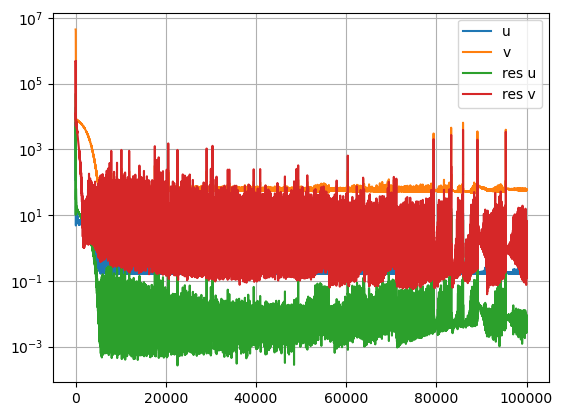

In [22]:
plt.plot(losses[:, 0], label='u')
plt.plot(losses[:, 1], label='v')
plt.plot(losses[:, 2], label='res u')
plt.plot(losses[:, 3], label='res v')
plt.yscale('log')
plt.grid(); plt.legend(); plt.show()

In [13]:
(u, u_xx, u_yy, u_xy, u_yx, u_t, 
 v, v_xx, v_yy, v_xy, v_yx, v_t) = grads(pinn, pattern.t_star[-1:].astype(np.float32))

In [14]:
def RMSE(arr1, arr2):
    #return np.sqrt(np.mean(((arr1-arr2)/np.max(arr2))**2))
    #return np.sqrt(np.mean(((arr1-arr2)/(arr2+1e-20))**2))
    return np.sqrt(np.mean(((arr1-arr2))**2))
                          
print("u: ", RMSE(u, pattern.c[0,:, : , -1]))
print("v: ", RMSE(v, pattern.c[1,:, : , -1]))
print("u_xx: ", RMSE(u_xx, pattern.c_xx[0,:, : , -1]))
print("v_xx: ", RMSE(v_xx, pattern.c_xx[1,:, : , -1]))
print("u_yy: ", RMSE(u_yy, pattern.c_yy[0,:, : , -1]))
print("v_yy: ", RMSE(v_yy, pattern.c_yy[1,:, : , -1]))
print("u_t: ", RMSE(u_t, pattern.c_t[0,:, : , -1]))
print("v_t: ", RMSE(v_t, pattern.c_t[1,:, : , -1]))

u:  0.00088454294
v:  0.022975337
u_xx:  0.001161985
v_xx:  0.0037356347
u_yy:  0.0017973285
v_yy:  0.0057538194
u_t:  0.00024827558
v_t:  0.0065966267


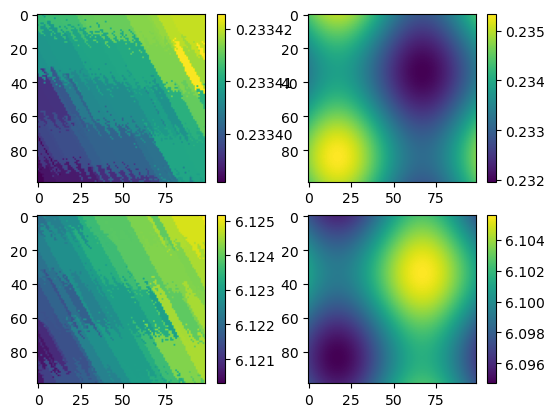

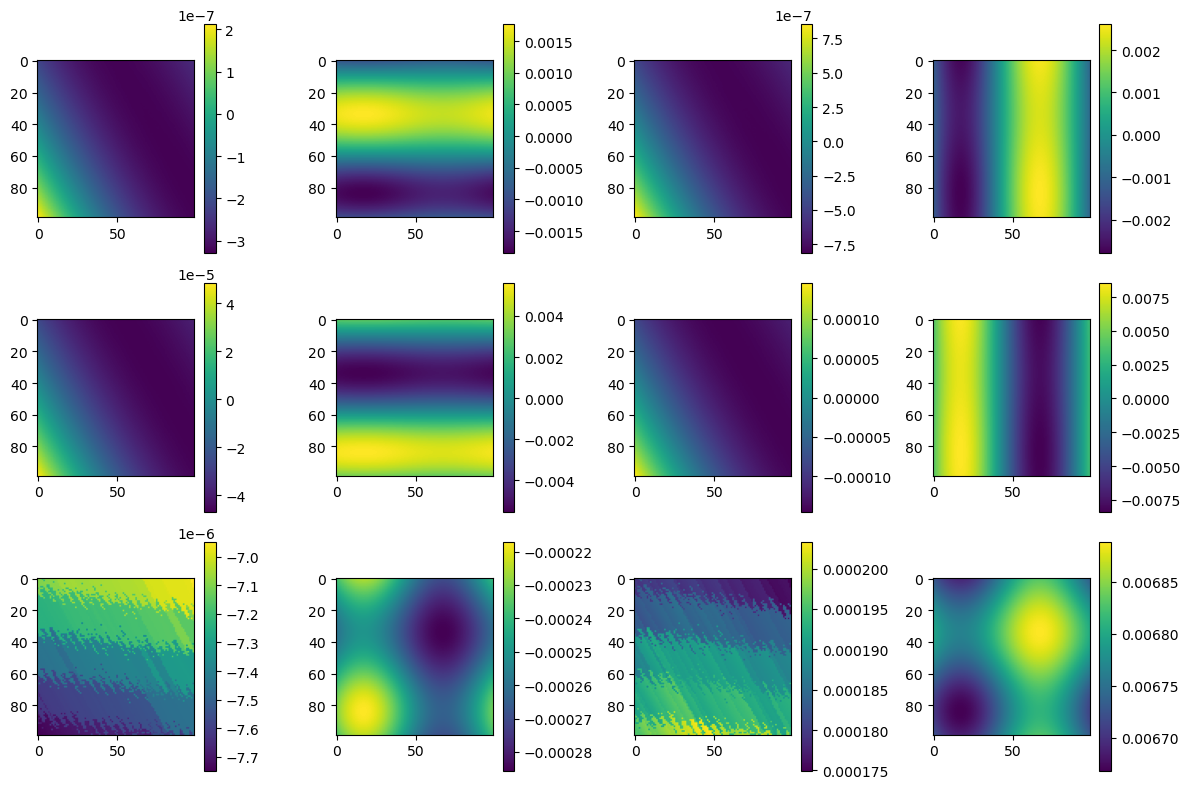

In [15]:
plt.subplot(221)
plt.imshow(u)
plt.colorbar()
plt.subplot(222)
plt.imshow(pattern.c[0,:,:,-1])
plt.colorbar()
plt.subplot(223)
plt.imshow(v)
plt.colorbar()
plt.subplot(224)
plt.imshow(pattern.c[1,:,:,-1])
plt.colorbar()
plt.show()

plt.figure(figsize=(12, 8))
plt.subplot(341)
plt.imshow(u_xx)
plt.colorbar()
plt.subplot(342)
plt.imshow(pattern.c_xx[0,:, : , -1])
plt.colorbar()
plt.subplot(343)
plt.imshow(u_yy)
plt.colorbar()
plt.subplot(344)
plt.imshow(pattern.c_yy[0,:, : , -1])
plt.colorbar()
plt.subplot(345)
plt.imshow(v_xx)
plt.colorbar()
plt.subplot(346)
plt.imshow(pattern.c_xx[1,:, : , -1])
plt.colorbar()
plt.subplot(347)
plt.imshow(v_yy)
plt.colorbar()
plt.subplot(3,4,8)
plt.imshow(pattern.c_yy[1,:, : , -1])
plt.colorbar()
plt.tight_layout()
plt.subplot(3,4,9)
plt.imshow(u_t)
plt.colorbar()
plt.subplot(3,4,10)
plt.imshow(pattern.c_t[0,:, : , -1])
plt.colorbar()
plt.subplot(3,4,11)
plt.imshow(v_t)
plt.colorbar()
plt.subplot(3,4,12)
plt.imshow(pattern.c_t[1,:, : , -1])
plt.colorbar()
plt.tight_layout()
plt.show()